## Multilabel Classification of Research Articles

Dataset Source: https://www.kaggle.com/datasets/shivanandmn/multilabel-classification-dataset

#### Install Necessary Libraries

In [1]:
%pip install scikit-learn transformers torch evaluate datasets tensorboard
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.0 MB/s eta 0:00:00


#### Enter HuggingFace Access Token

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Necessary Libraries

In [18]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

import transformers
from transformers import (
    DataCollatorForSeq2Seq,
    AutoTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed
)

import datasets
from datasets import Dataset, DatasetDict

import evaluate

import torch

!git lfs install

Git LFS initialized.


#### Display Version of Relevant Libraries

In [5]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("NumPy:".rjust(15), np.__version__)
print("Torch:".rjust(15), transformers.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.10.1
        Pandas: 1.5.3
         NumPy: 1.23.5
         Torch: 4.31.0
  Transformers: 4.31.0
      Datasets: 2.14.4
      Evaluate: 0.4.0


#### Ingest Data & Drop Unnecessary Feature

In [6]:
df = pd.read_csv("/content/drive/MyDrive/NLP Regression/train.csv")

df.drop(columns=['ID'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TITLE                 20972 non-null  object
 1   ABSTRACT              20972 non-null  object
 2   Computer Science      20972 non-null  int64 
 3   Physics               20972 non-null  int64 
 4   Mathematics           20972 non-null  int64 
 5   Statistics            20972 non-null  int64 
 6   Quantitative Biology  20972 non-null  int64 
 7   Quantitative Finance  20972 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.3+ MB


#### Data Preprocessing

In [7]:
df['text'] = df["TITLE"] + " : " + df["ABSTRACT"]

df.drop(columns=["TITLE", "ABSTRACT"], inplace=True)

df.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps : ...
1,1,0,0,0,0,0,Rotation Invariance Neural Network : Rotatio...
2,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,0,0,1,0,0,0,A finite element approximation for the stochas...
4,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


#### Visual: Histogram of Article Abstract's Word Lengths

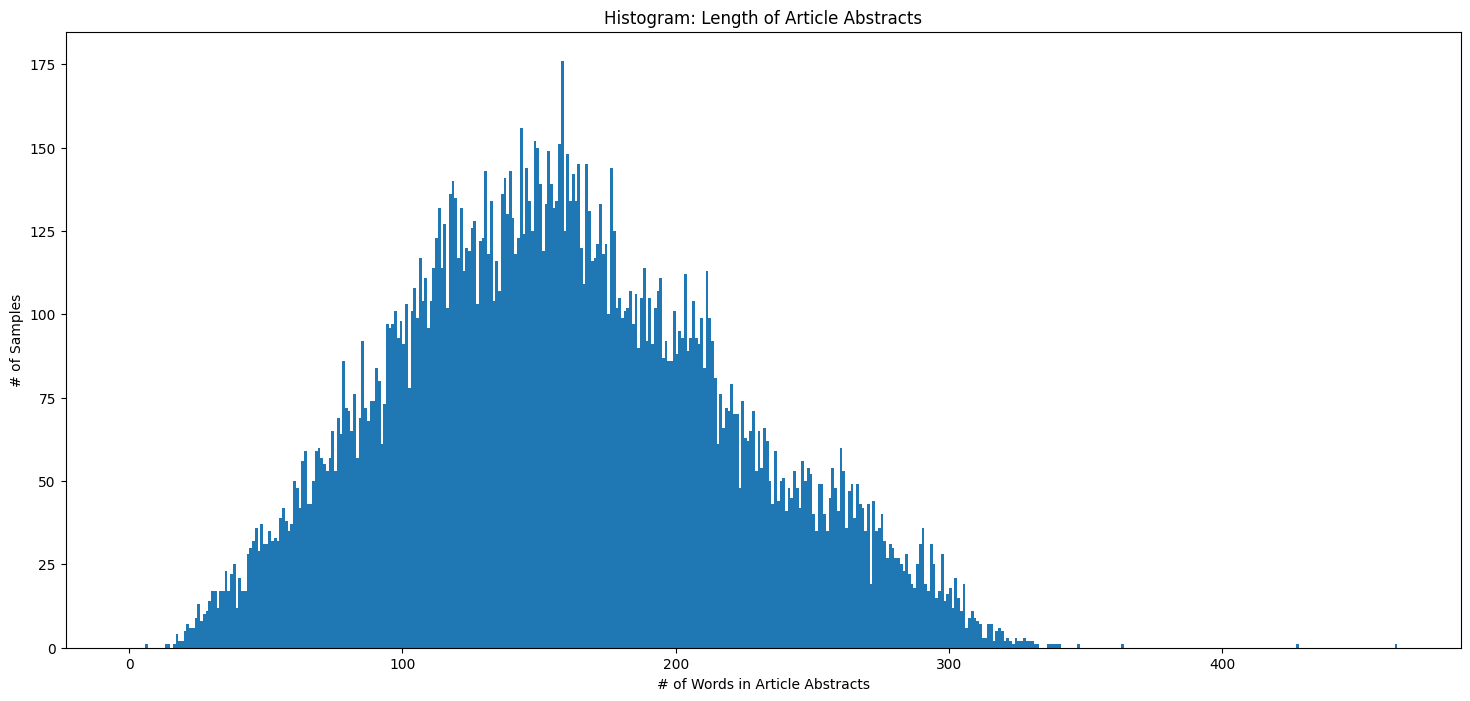

The maximum length of Article Abstracts (in words) is 463 words.


In [8]:
df['text_length'] = df['text'].str.split().str.len()

n_bin=464
df.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Article Abstracts')
plt.xlabel('# of Words in Article Abstracts')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Article Abstracts (in words) is {max(df['text_length'])} words.")

#### Data Preprocessing

In [9]:
upper_limit=350

# This only removes 3 samples (out of nearly 21,000 total samples)
df = df[df['text_length'] < (upper_limit + 1)]

df.drop(columns=["text_length", "Quantitative Finance"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20969 entries, 0 to 20971
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Computer Science      20969 non-null  int64 
 1   Physics               20969 non-null  int64 
 2   Mathematics           20969 non-null  int64 
 3   Statistics            20969 non-null  int64 
 4   Quantitative Biology  20969 non-null  int64 
 5   text                  20969 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


<ipython-input-9-82aa653d0211>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["text_length", "Quantitative Finance"], inplace=True)


#### Create List of Labels & Dictionaries for Converting Between Strings & Integers

In [10]:
labels = [x for x in df.columns if x not in ['text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

#### Convert Pandas DataFrame to Datasets & Split into Training/Testing/Evaluation Datasets

In [11]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)
ds['train'][25]

Training Dataset Shape: (16775, 7)
Testing Dataset Shape: (2097, 7)
Evaluation Dataset Shape: (2097, 7)


{'Computer Science': 0,
 'Physics': 0,
 'Mathematics': 1,
 'Statistics': 0,
 'Quantitative Biology': 0,
 'text': 'On the synthesis of acoustic sources with controllable near fields :   In this paper we present a strategy for the the synthesis of acoustic sources\nwith controllable near fields in free space and finite depth homogeneous ocean\nenvironments. We first present the theoretical results at the basis of our\ndiscussion and then, to illustrate our findings we focus on the following three\nparticular examples:\n1. acoustic source approximating a prescribed field pattern in a given\nbounded sub- region of its near field. 2. acoustic source approximating\ndifferent prescribed field patterns in given disjoint bounded near field\nsub-regions. 3. acoustic source approximating a prescribed back-propagating\nfield in a given bounded near field sub-region while maintaining a very low far\nfield signature.\nFor each of these three examples, we discuss the optimization scheme used to\nappr

#### Basic Values/Constants

In [12]:
set_seed = 42
NUM_OF_EPOCHS = 3

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = int(upper_limit * 1.3)
MODEL_CKPT = "bert-base-uncased"

METRIC_NAME = "f1"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cuda")
print(f"This project is being traned using {DEVICE}")

This project is being traned using cuda


#### Create Tokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def data_preprocessor(examples):
	# get a batch of text
	text = examples["text"]
	# encode them
	encoded_data = tokenizer(text,
	                         truncation=True)
	# add labels
	labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
	# create numpy array
	labels_matrix = np.zeros((len(text), len(labels)))
	# load numpy array
	for idx, label in enumerate(labels):
		labels_matrix[:, idx] = labels_batch[label]

	encoded_data["labels"] = labels_matrix.tolist()

	return encoded_data

#### Tokenize Dataset

In [14]:
encoded_ds = ds.map(data_preprocessor,
                    batched=True,
                    load_from_cache_file=False)
encoded_ds.set_format("torch")

Map:   0%|          | 0/16775 [00:00<?, ? examples/s]

Map:   0%|          | 0/2097 [00:00<?, ? examples/s]

Map:   0%|          | 0/2097 [00:00<?, ? examples/s]

#### Print Dataset Shapes to Make Sure Prepared for Later

In [15]:
print(encoded_ds['train'].shape)
print(encoded_ds['test'].shape)
print(encoded_ds['eval'].shape)

(16775, 11)
(2097, 11)
(2097, 11)


#### Define Model

In [19]:
model = (BertForSequenceClassification.from_pretrained(MODEL_CKPT,
                                                             problem_type="multi_label_classification",
                                                             num_labels=len(labels),
                                                             id2label=id2label,
                                                             label2id=label2id)
         ).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Create Metrics Evaluation Function

In [20]:
def multi_label_metrics(predictions,
                        labels,
                        threshold=0.5):
    '''
    This function calculates & returns metrics
    for a multilabel classification analysis.
    '''

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)

    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    preds = preds[0] if isinstance(preds,
                    tuple) else preds
    results = multi_label_metrics(
                    predictions=preds,
                    labels=labels)
    return results

#### Define Training Arguments

In [21]:
args = TrainingArguments(
    output_dir=MODEL_CKPT + "-Research_Articles_Multilabel",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    log_level="error",
    logging_first_step=True,
    logging_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCHS,
    auto_find_batch_size=True,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC_NAME,
    greater_is_better=True,
    weight_decay=0.01,
    group_by_length=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Trainer

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Research_Articles_Multilabel into local empty directory.


#### Train Model

In [23]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.242500,0.194812,0.834793,0.892085,0.706724
2,0.173900,0.198620,0.834789,0.892623,0.707201
3,0.132800,0.203852,0.840479,0.897648,0.708155


#### Save Model & Metrics on Training Dataset

In [24]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file runs/Aug10_18-43-29_b6821e1c31c4/events.out.tfevents.1691693027.b6821e1c31c4.294.0:   0%|         …

To https://huggingface.co/DunnBC22/bert-base-uncased-Research_Articles_Multilabel
   0970a3a..c6d56ec  main -> main

   0970a3a..c6d56ec  main -> main

To https://huggingface.co/DunnBC22/bert-base-uncased-Research_Articles_Multilabel
   c6d56ec..58f57d3  main -> main

   c6d56ec..58f57d3  main -> main



***** train metrics *****
  epoch                    =        3.0
  total_flos               =  5523001GF
  train_loss               =     0.1831
  train_runtime            = 0:43:04.83
  train_samples_per_second =     19.469
  train_steps_per_second   =      2.434


#### Evaluate Model

In [25]:
trainer.evaluate()

{'eval_loss': 0.20385245978832245,
 'eval_f1': 0.8404789494013132,
 'eval_roc_auc': 0.897647591573035,
 'eval_accuracy': 0.7081545064377682,
 'eval_runtime': 52.0127,
 'eval_samples_per_second': 40.317,
 'eval_steps_per_second': 5.056,
 'epoch': 3.0}

#### Push Model to HuggingFace Hub (My Profile!)

In [26]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Upload file runs/Aug10_18-43-29_b6821e1c31c4/events.out.tfevents.1691695729.b6821e1c31c4.294.1: 100%|#########…

To https://huggingface.co/DunnBC22/bert-base-uncased-Research_Articles_Multilabel
   58f57d3..ab17dc7  main -> main

   58f57d3..ab17dc7  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Research_Articles_Multilabel/commit/ab17dc72f762ffaf1766a7958e79d7fab37a3ea8'

### Notes & Other Takeaways From This Project
****
- I was expecting a larger improvement from my model that used the Distilbert-base-uncased checkpoint even though this model was trained for 3 epochs instead of the 5 epochs that the Distilbert model was trained. Here is why:

| Metric Name | Bert-Base-Uncased Checkpoint | Distilbert-Base-Uncased Checkpoint | Bert Improvement Over Distilbert |
|:-----:|:-----:|:-----:|:-----:|
| F1 | 0.8405 | 0.8395 | 0.0010 |
| ROC AUC | 0.8976 | 0.8909 | 0.0067 |
| Subset Accuracy | 0.7082 | 0.6977 | 0.0105 |

* All values in the chart above were rounded to the nearest ten-thousandth.

****

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}